# 06 - calculate_censo_nan_values (ccnv) v1 __negative values check__

This notebook checks for a specific AGEB where negative population values were found on pobcenso_inegi_20 data.

__NOTE: The original function has been edited and the Analysis and Diagnosis cannot be replicated.__

__Analysis (Full explanation in Miro):__
* Original (censo_inegi_20_mza and censo_inegi_20_ageb) data is loaded
* calculate_censo_nan_values_v1 is used with additional prints that revealed that p_0a2 (that has 22 people in ageb data) registers +100 people when calculating p_0a2 = pobtot - p_3ymas.

__Diagnosis:__
* The error is most likely due to the fact that __pobtot, pobfem and pobmas include more pop data than the sub groups:__
> _"Incluye la estimación del número
 de personas en viviendas particulares sin información de
 ocupantes. Incluye a la población que no especificó su
 edad."_

__Implications:__
* Using calculate_censo_nan_values function is not a reliable way to calculate nan values in population sub groups.

__Implemented solution:__
* Inside calculate_censo_nan_values_v1, implement 'POBTOT_ages', 'POBFEM_ages' and 'POBMAS_ages'. Three 'total' population categories that should get obtained from adding age-groups exclusively. (Just in case this cannot be done are POBTOT, POBFEM and POBMAS used).

__Result:__
* SUCCESS. No more negative values.

__Caveats:__
* Since sometimes 'POBTOT_ages', 'POBFEM_ages' and 'POBMAS_ages' cannot be calculated and 'POBTOT', 'POBFEM' and 'POBMAS' are sometimes used, which can result in greater than real block population concentrations on blocks where NaN values remained after attempting to find NaN values using known relations between age groups (See function calculate_censo_nan_values)

## Import libraries

In [1]:
main_folder_path = '../../../'

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(main_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Notebook config

In [3]:
# After GIS check, found AGEB in Guadalajara that has negative values in p_0a2 in 5 of its blocks.
# Other discrepancies were found.

# AGEB of interest
cvegeo_ageb_interest = '1403900012130'

## Load data

In [4]:
blocks_schema = 'sociodemografico'
blocks_table = 'censo_inegi_20_mza'

query = f"SELECT * FROM {blocks_schema}.{blocks_table} WHERE \"cvegeo_ageb\" LIKE \'{cvegeo_ageb_interest}%%\'"
blocks_gdf = aup.gdf_from_query(query, geometry_col='geometry')

# Show
print(len(blocks_gdf.cvegeo_ageb.unique()))
print(blocks_gdf.crs)
print(blocks_gdf.shape)
blocks_gdf.head(2)

1
EPSG:4326
(26, 237)


,nom_ent,nom_mun,nom_loc,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,cve_loc,cve_ageb,cve_mza,cvegeo_mun,cvegeo_loc,cvegeo_ageb,cvegeo_mza,ambito,tipomza,geometry
0,Jalisco,Guadalajara,Guadalajara,6,NaN,NaN,NaN,NaN,NaN,NaN,...,0001,2130,005,14039,140390001,1403900012130,1403900012130005,Urbana,Típica,"POLYGON ((-103.37302 20.66594, -103.37302 20.6..."
1,Jalisco,Guadalajara,Guadalajara,8,4.0,4.0,0.0,0.0,0.0,NaN,...,0001,2130,006,14039,140390001,1403900012130,1403900012130006,Urbana,Típica,"POLYGON ((-103.3725 20.66687, -103.37262 20.66..."


In [5]:
agebs_schema = 'sociodemografico'
agebs_table = 'censo_inegi_20_ageb'

query = f"SELECT * FROM {agebs_schema}.{agebs_table} WHERE \"cvegeo_ageb\" LIKE \'{cvegeo_ageb_interest}%%\'"
ageb_gdf = aup.gdf_from_query(query, geometry_col='geometry')

# Show
print(len(ageb_gdf.cvegeo_ageb.unique()))
print(ageb_gdf.crs)
print(ageb_gdf.shape)
ageb_gdf.head(2)

1
EPSG:4326
(1, 235)


,nom_ent,nom_mun,nom_loc,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,cve_ent,cve_mun,cve_loc,cve_ageb,cve_mza,cvegeo_mun,cvegeo_loc,cvegeo_ageb,cvegeo_mza,geometry
0,Jalisco,Guadalajara,Total AGEB urbana,1943,914.0,1029.0,22.0,7.0,15.0,826.0,...,14,039,0001,2130,000,14039,140390001,1403900012130,1403900012130000,"MULTIPOLYGON (((-103.36841 20.66833, -103.3684..."


<Axes: >

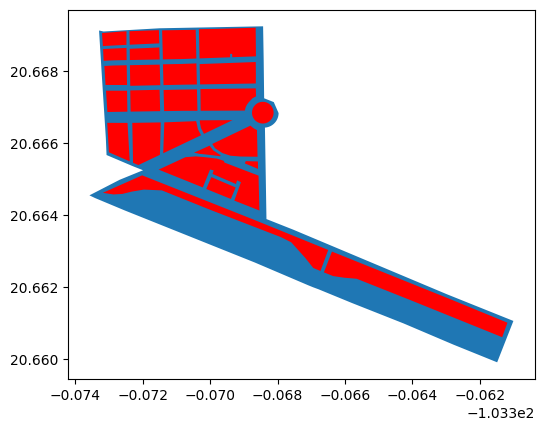

In [6]:
fig,ax = plt.subplots()

blocks_gdf.plot(zorder=1,color='red',ax=ax)
ageb_gdf.plot(zorder=0,ax=ax)

## Analysis and Diagnosis [Previous, before modifing function]

In [7]:
pop_mza_gdf_calc = aup.calculate_censo_nan_values_v1(ageb_gdf,blocks_gdf,year='2020',extended_logs=True,main_folder_path=main_folder_path)

# Show
#print(pop_mza_gdf_calc.crs)
print(pop_mza_gdf_calc.shape)
pop_mza_gdf_calc.head(2)

INSPECTING AGEBs.
FOUND 1 blocks_800 in current municipalities.
ADDED 0 blocks_800 for 0 AGEBs.
Printing AGEBs with blocks_800 list:
[]
REMOVED blocks_800 from 1 other AGEBs not available in pop_gdf_ageb.
Printing AGEBs from blocks_800 that won't be used.
['1403900013482']
STARTING NANs calculation.
----------------------------------------
Calculating NaNs for AGEB 1403900012130 (1/1.)
Calculating NaNs. 10% done.
Calculating NaNs using block data for AGEB 1403900012130.
Initial p_0a2 value: 17.0.
Loop 1 parent fill: 17.0.
Loop 1 p3ymas fill: 139.0.
Loop 1 p_12ymas fill: 139.0.
Loop 1 p_15ymas fill: 139.0.
Loop 1 p_18ymas fill: 139.0.
Loop 1 POB0_14 fill: 139.0.
Round 1 Starting with 305 nan values. Finishing with 240 nan values.
Loop 2 parent fill: 139.0.
Loop 2 p3ymas fill: 139.0.
Loop 2 p_12ymas fill: 139.0.
Loop 2 p_15ymas fill: 139.0.
Loop 2 p_18ymas fill: 139.0.
Loop 2 POB0_14 fill: 139.0.
Round 2 Starting with 240 nan values. Finishing with 238 nan values.
Loop 3 parent fill: 139

,nom_ent,nom_mun,nom_loc,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,cve_loc,cve_ageb,cve_mza,cvegeo_mun,cvegeo_loc,cvegeo_ageb,cvegeo_mza,ambito,tipomza,geometry
0,Jalisco,Guadalajara,Guadalajara,0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0001,2130,001,14039,140390001,1403900012130,1403900012130001,Urbana,Típica,"POLYGON ((-103.37149 20.66723, -103.37148 20.6..."
1,Jalisco,Guadalajara,Guadalajara,6,2.192308,3.807692,-13.5,0.0,-6.692308,4.153846,...,0001,2130,005,14039,140390001,1403900012130,1403900012130005,Urbana,Típica,"POLYGON ((-103.37302 20.66594, -103.37302 20.6..."


In [15]:
blocks_gdf[['pobtot','p_0a2','p_3ymas']]

,pobtot,p_0a2,p_3ymas
0,0,0.0,0.0
1,6,NaN,NaN
2,8,0.0,NaN
3,5,NaN,NaN
4,4,NaN,NaN
5,29,0.0,29.0
6,58,0.0,42.0
7,12,0.0,12.0
8,22,0.0,21.0
9,1059,13.0,282.0


In [16]:
ageb_gdf[['pobtot','p_0a2','p_3ymas']]

,pobtot,p_0a2,p_3ymas
0,1943,22.0,826.0


## Analysis [After modifying function]

In [7]:
pop_mza_gdf_calc = aup.calculate_censo_nan_values_v1(ageb_gdf,
                                                     blocks_gdf,
                                                     year='2020',
                                                     extended_logs=True,
                                                     main_folder_path=main_folder_path)
# Show
print(pop_mza_gdf_calc.shape)
pop_mza_gdf_calc.head(2)

INSPECTING AGEBs.
Blocks800 - FOUND 1 blocks_800 in current municipalities.
Blocks800 - ADDED 0 blocks_800 for 0 AGEBs.
Blocks800 - Printing AGEBs with blocks_800 list:
[]
Blocks800 - Not considering blocks_800 from 1 other AGEBs not available in pop_gdf_ageb.
Blocks800 - Printing AGEBs from blocks_800 that won't be used.
['1403900013482']
STARTING NANs CALCULATION.


Calculating NaNs:   0%|                                                                                                                                                                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

----------------------------------------
Calculating NaNs for AGEB 1403900012130 (1/1.)
Calculating NaNs using known relations for AGEB 1403900012130.
Round 1 Starting with 383 nan values. Finishing with 283 nan values.
Round 2 Starting with 283 nan values. Finishing with 275 nan values.
Round 3 Starting with 275 nan values. Finishing with 274 nan values.
Round 4 Starting with 274 nan values. Finishing with 274 nan values.
Originally had 383 nan values, now there are 274. A 28.46% reduction.


Calculating NaNs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.14it/s]

Calculating NaNs distributing AGEB data for AGEB 1403900012130.
Note: Filled 6 POBTOT_ages NaN values using POBTOT data out of 26 blocks with data.
2.5% of columns solved using known relations only.
97.5% of columns required distributing AGEB data.
Finished calculating NaNs.
Percentage of NaNs found using blocks gdf: 28.46%.
Columns which could be solved entirely using known relations: 1.0 (2.5%).
Columns which required distributing AGEB data: 39.0 (97.5%).
Columns which couldn't be solved: 0.0 (0.0%).
(26, 237)


,nom_ent,nom_mun,nom_loc,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,cve_loc,cve_ageb,cve_mza,cvegeo_mun,cvegeo_loc,cvegeo_ageb,cvegeo_mza,ambito,tipomza,geometry
0,Jalisco,Guadalajara,Guadalajara,6,2.192308,3.807692,0.0,0.072289,0.072289,4.400000,...,0001,2130,005,14039,140390001,1403900012130,1403900012130005,Urbana,Típica,"POLYGON ((-103.37302 20.66594, -103.37302 20.6..."
1,Jalisco,Guadalajara,Guadalajara,8,4.000000,4.000000,0.0,0.000000,0.000000,5.866667,...,0001,2130,006,14039,140390001,1403900012130,1403900012130006,Urbana,Típica,"POLYGON ((-103.3725 20.66687, -103.37262 20.66..."


In [27]:
columns_of_interest = ['POBTOT','POBFEM','POBMAS',
						 'P_0A2','P_0A2_F','P_0A2_M',
						 'P_3A5','P_3A5_F','P_3A5_M',
						 'P_6A11','P_6A11_F','P_6A11_M',
						 'P_12A14','P_12A14_F','P_12A14_M',
						 'P_15A17','P_15A17_F','P_15A17_M',
						 'P_18A24','P_18A24_F','P_18A24_M',
						 'P_60YMAS','P_60YMAS_F','P_60YMAS_M',
						 'P_3YMAS','P_3YMAS_F','P_3YMAS_M',
						 'P_12YMAS','P_12YMAS_F','P_12YMAS_M',
						 'P_15YMAS','P_15YMAS_F','P_15YMAS_M',
						 'P_18YMAS','P_18YMAS_F','P_18YMAS_M',
						 'REL_H_M','POB0_14','POB15_64','POB65_MAS']

columns_of_interest_lower = [col.lower() for col in columns_of_interest]

for col in columns_of_interest_lower:
    if len(pop_mza_gdf_calc.loc[pop_mza_gdf_calc[col]<0])>=1:
        print(f"Negative values in col {col}.")
print(f"Finished looking for negative values in columns.")

Finished looking for negative values in columns.


In [28]:
# DATA IN AGEB
ageb_gdf[['pobtot','p_0a2','p_0a2_f','p_0a2_m']]

,pobtot,p_0a2,p_0a2_f,p_0a2_m
0,1943,22.0,7.0,15.0


In [29]:
# DATA IN CALCULATED COLUMNS
print(pop_mza_gdf_calc.pobtot.sum())
print(pop_mza_gdf_calc.p_0a2.sum())
print(pop_mza_gdf_calc.p_0a2_f.sum())
print(pop_mza_gdf_calc.p_0a2_m.sum())

pop_mza_gdf_calc[['pobtot','p_0a2','p_0a2_f','p_0a2_m']]

1943
22.0
7.0
15.0


,pobtot,p_0a2,p_0a2_f,p_0a2_m
0,6,0.0,0.072289,0.072289
1,8,0.0,0.000000,0.000000
2,0,0.0,0.000000,0.000000
3,5,0.0,0.060241,0.060241
4,4,0.0,0.048193,0.048193
5,29,0.0,0.000000,0.000000
6,58,0.0,0.000000,0.000000
7,12,0.0,0.000000,0.000000
8,22,0.0,0.000000,0.000000
9,1059,13.0,5.000000,8.000000


In [30]:
# ORIGINAL BLOCKS GDF
blocks_gdf[['pobtot','p_0a2','p_0a2_f','p_0a2_m']]

,pobtot,p_0a2,p_0a2_f,p_0a2_m
0,6,NaN,NaN,NaN
1,8,0.0,0.0,0.0
2,0,0.0,0.0,0.0
3,5,NaN,NaN,NaN
4,4,NaN,NaN,NaN
5,29,0.0,0.0,0.0
6,58,0.0,0.0,0.0
7,12,0.0,0.0,0.0
8,22,0.0,0.0,0.0
9,1059,13.0,5.0,8.0


## Full city (Guadalajara) analysis [After modifying function and script]

### __Full city (Guadalajara) analysis__ - Look for negative values in any of the products

In [34]:
columns_of_interest = ['POBTOT','POBFEM','POBMAS',
						 'P_0A2','P_0A2_F','P_0A2_M',
						 'P_3A5','P_3A5_F','P_3A5_M',
						 'P_6A11','P_6A11_F','P_6A11_M',
						 'P_12A14','P_12A14_F','P_12A14_M',
						 'P_15A17','P_15A17_F','P_15A17_M',
						 'P_18A24','P_18A24_F','P_18A24_M',
						 'P_60YMAS','P_60YMAS_F','P_60YMAS_M',
						 'P_3YMAS','P_3YMAS_F','P_3YMAS_M',
						 'P_12YMAS','P_12YMAS_F','P_12YMAS_M',
						 'P_15YMAS','P_15YMAS_F','P_15YMAS_M',
						 'P_18YMAS','P_18YMAS_F','P_18YMAS_M',
						 'REL_H_M','POB0_14','POB15_64','POB65_MAS']

columns_of_interest_lower = [col.lower() for col in columns_of_interest]

In [44]:
gdf_dir = main_folder_path+f'data/scripts_output/script_22/script22_2020Guadalajara_pop_mza_gdf_calc.gpkg'
blocks_fixed = gpd.read_file(gdf_dir)

for col in columns_of_interest_lower:
    if len(blocks_fixed.loc[blocks_fixed[col]<0])>=1:
        print(f"Negative values in col {col}.")
print(f"Finished looking for negative values in columns.")

# Show
print(blocks_fixed.shape)
blocks_fixed.head(2)

Finished looking for negative values in columns.
(54804, 238)


,nom_ent,nom_mun,nom_loc,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,cve_ageb,cve_mza,cvegeo_mun,cvegeo_loc,cvegeo_ageb,cvegeo_mza,ambito,tipomza,city,geometry
0,Jalisco,Zapopan,Tesistán (San Francisco Tesistán),34,16.0,18.0,2.0,1.012766,1.157447,32.0,...,6692,019,14120,141200231,1412002316692,1412002316692019,Urbana,Típica,Guadalajara,"POLYGON ((-103.46986 20.80859, -103.46943 20.8..."
1,Jalisco,Zapopan,Tesistán (San Francisco Tesistán),27,11.0,16.0,4.0,0.804255,0.919149,23.0,...,6692,001,14120,141200231,1412002316692,1412002316692001,Urbana,Típica,Guadalajara,"POLYGON ((-103.46742 20.80681, -103.4684 20.80..."


In [45]:
gdf_dir = main_folder_path+f'data/scripts_output/script_22/script22_2020Guadalajara_pop_nodes_gdf.gpkg'
nodes_fixed = gpd.read_file(gdf_dir)

for col in columns_of_interest_lower:
    if col == 'rel_h_m':
        continue
    if len(nodes_fixed.loc[nodes_fixed[col]<0])>=1:
        print(f"Negative values in col {col}.")
print(f"Finished looking for negative values in columns.")

# Show
print(nodes_fixed.shape)
nodes_fixed.head(2)

Finished looking for negative values in columns.
(160369, 44)


,osmid,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,p_3a5_m,...,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,pcon_disc,dens_pob_ha,city,geometry
0,1363860294,3.430193,2.012226,1.417967,0.175312,0.170672,0.004640,0.342891,0.170672,0.172219,...,2.133138,1.238014,0.895123,0.954938,2.125404,0.349852,0.344438,15.952395,Guadalajara,POINT (-103.38258 20.62988)
1,1041108398,8.505745,4.803604,3.702141,0.214173,0.091789,0.122385,0.260068,0.122385,0.137683,...,6.761761,3.916314,2.845447,1.346233,6.302818,0.856694,0.183577,68.749355,Guadalajara,POINT (-103.40187 20.6725)


In [46]:
gdf_dir = main_folder_path+f'data/scripts_output/script_22/script22_2020Guadalajara_hex.gpkg'
hex_fixed = gpd.read_file(gdf_dir)

for col in columns_of_interest_lower:
    if col == 'rel_h_m':
        continue
    if len(hex_fixed.loc[hex_fixed[col]<0])>=1:
        print(f"Negative values in col {col}.")
print(f"Finished looking for negative values in columns.")

# Show
print(hex_fixed.shape)
hex_fixed.head(2)

Finished looking for negative values in columns.
(1140, 48)


,hex_id,cvegeo,nomgeo,city,type,res,pobtot,pobfem,pobmas,p_0a2,...,p_15ymas_m,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,pcon_disc,dens_pob_ha,geometry
0,88498c9421fffff,14039,Guadalajara,Guadalajara,urban,8,16610.550781,8517.853516,8092.696289,632.171021,...,6216.345703,12180.633789,6407.115234,5773.518555,3611.871826,11033.306641,1965.371338,1013.803528,191.892430,"POLYGON ((-103.28663 20.69309, -103.28209 20.6..."
1,88498c9405fffff,14039,Guadalajara,Guadalajara,urban,8,11351.236328,5845.824219,5505.411621,417.351807,...,4342.500977,8530.443359,4476.526367,4053.916504,2273.001221,7973.125000,1102.157959,543.825073,131.130016,"POLYGON ((-103.30025 20.68392, -103.29571 20.6..."


### __Full city (Guadalajara) analysis__ - Check for population differences (Expected but slightly. Passed test)

In [11]:
# Cities (database)
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'
city = 'Guadalajara'
year = '2020'

# Load metro
metro_query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
city_gdf = aup.gdf_from_query(metro_query, geometry_col='geometry')
city_gdf = city_gdf.set_crs("EPSG:4326")

# Create a tupple from a list with all unique cvegeo_mun ('CVE_ENT'+'CVE_MUN') of current city
city_gdf['cvegeo_mun'] = city_gdf['CVE_ENT']+city_gdf['CVE_MUN']
cvegeo_mun_lst = list(city_gdf.cvegeo_mun.unique())
# To avoid error that happens when there's only one MUN in State: 
# e.g.: <<< SELECT * FROM sociodemografico.censo_inegi_{year[2:]}_mza WHERE ("entidad" = '02') AND "mun" IN ('001',) >>>
# Duplicate mun inside tupple if there's only one MUN.
if len(cvegeo_mun_lst) >= 2:
    cvegeo_mun_tpl = str(tuple(cvegeo_mun_lst))
else:
    cvegeo_mun_lst.append(cvegeo_mun_lst[0])
    cvegeo_mun_tpl = str(tuple(cvegeo_mun_lst))
aup.log(f"--- Area of interest muns: {cvegeo_mun_tpl}.")

# Load AGEBs and blocks
print("Loading AGEBS")
ageb_query = f"SELECT * FROM sociodemografico.censo_inegi_{year[2:]}_ageb WHERE \"cvegeo_mun\" IN {cvegeo_mun_tpl}"
pop_ageb_gdf = aup.gdf_from_query(ageb_query, geometry_col='geometry')
# Set CRS
pop_ageb_gdf = pop_ageb_gdf.set_crs("EPSG:4326")

# Show
print(pop_ageb_gdf.shape)
pop_ageb_gdf.head(2)

Loading AGEBS
(1955, 235)


,nom_ent,nom_mun,nom_loc,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,cve_ent,cve_mun,cve_loc,cve_ageb,cve_mza,cvegeo_mun,cvegeo_loc,cvegeo_ageb,cvegeo_mza,geometry
0,Jalisco,San Pedro Tlaquepaque,Total AGEB urbana,7,NaN,NaN,NaN,NaN,NaN,NaN,...,14,098,0001,3110,000,14098,140980001,1409800013110,1409800013110000,"MULTIPOLYGON (((-103.38193 20.58786, -103.3818..."
1,Jalisco,Tlajomulco de Zúñiga,Total AGEB urbana,24,12.0,12.0,NaN,0.0,NaN,23.0,...,14,097,0041,3306,000,14097,140970041,1409700413306,1409700413306000,"MULTIPOLYGON (((-103.30215 20.50058, -103.3020..."


In [13]:
columns_of_interest = ['POBTOT','POBFEM','POBMAS',
						 'P_0A2','P_0A2_F','P_0A2_M',
						 'P_3A5','P_3A5_F','P_3A5_M',
						 'P_6A11','P_6A11_F','P_6A11_M',
						 'P_12A14','P_12A14_F','P_12A14_M',
						 'P_15A17','P_15A17_F','P_15A17_M',
						 'P_18A24','P_18A24_F','P_18A24_M',
						 'P_60YMAS','P_60YMAS_F','P_60YMAS_M',
						 'P_3YMAS','P_3YMAS_F','P_3YMAS_M',
						 'P_12YMAS','P_12YMAS_F','P_12YMAS_M',
						 'P_15YMAS','P_15YMAS_F','P_15YMAS_M',
						 'P_18YMAS','P_18YMAS_F','P_18YMAS_M',
						 'REL_H_M','POB0_14','POB15_64','POB65_MAS']
columns_of_interest_lower = [col.lower() for col in columns_of_interest]

gdf_dir = main_folder_path+f'data/scripts_output/script_22/script22_2020Guadalajara_pop_mza_gdf_calc.gpkg'
blocks_fixed = gpd.read_file(gdf_dir)

for col in columns_of_interest_lower:
    if len(blocks_fixed.loc[blocks_fixed[col]<0])>=1:
        print(f"Negative values in col {col}.")
print(f"Finished looking for negative values in columns.")

# Show
print(blocks_fixed.shape)
blocks_fixed.head(2)

Finished looking for negative values in columns.
(54804, 238)


,nom_ent,nom_mun,nom_loc,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,cve_ageb,cve_mza,cvegeo_mun,cvegeo_loc,cvegeo_ageb,cvegeo_mza,ambito,tipomza,city,geometry
0,Jalisco,Zapopan,Tesistán (San Francisco Tesistán),34,16.0,18.0,2.0,1.012766,1.157447,32.0,...,6692,019,14120,141200231,1412002316692,1412002316692019,Urbana,Típica,Guadalajara,"POLYGON ((-103.46986 20.80859, -103.46943 20.8..."
1,Jalisco,Zapopan,Tesistán (San Francisco Tesistán),27,11.0,16.0,4.0,0.804255,0.919149,23.0,...,6692,001,14120,141200231,1412002316692,1412002316692001,Urbana,Típica,Guadalajara,"POLYGON ((-103.46742 20.80681, -103.4684 20.80..."


In [25]:
# Find AGEBs in common to avoid comparison problems
agebs_in_ageb_gdf = list(pop_ageb_gdf['cvegeo_ageb'].unique()) #Previously 'CVE_AGEB'
agebs_in_mza_gdf = list(blocks_fixed['cvegeo_ageb'].unique()) #Previously 'CVE_AGEB'
missing_agebs = list(set(agebs_in_mza_gdf) - set(agebs_in_ageb_gdf))

summary_df = pd.DataFrame()
i=0
for ageb in agebs_in_mza_gdf:
    
    if ageb in missing_agebs:
        print(f"Missing AGEB {ageb}.")
    else:
        # Load blocks from current AGEB
        mza_ageb_gdf = blocks_fixed.loc[blocks_fixed['cvegeo_ageb'] == ageb].copy()
        # Load AGEB itself
        ageb_gdf = pop_ageb_gdf.loc[pop_ageb_gdf['cvegeo_ageb'] == ageb].copy()
        # Columns analysis
        for col in columns_of_interest_lower:
            if col == 'rel_h_m':
                continue
            blocks_value = mza_ageb_gdf[col].sum()
            ageb_value = ageb_gdf[col].unique()[0]
            value_diff = blocks_value-ageb_value
            
            summary_df.loc[i,'ageb'] = ageb
            summary_df.loc[i,'col'] = col
            summary_df.loc[i,'blocks_value'] = blocks_value
            summary_df.loc[i,'ageb_value'] = ageb_value
            summary_df.loc[i,'value_diff'] = round(value_diff,0)

    i+=1
            
summary_df

Missing AGEB 1407001161467.
Missing AGEB 1407001341467.


,ageb,col,blocks_value,ageb_value,value_diff
0,1412002316692,pob65_mas,61.000000,61.0,0.0
1,1412002434709,pob65_mas,328.812500,329.0,-0.0
2,1412002434713,pob65_mas,171.600000,172.0,-0.0
3,1412007560335,pob65_mas,29.000000,29.0,0.0
4,1412000017120,pob65_mas,58.894737,59.0,-0.0
...,...,...,...,...,...
1952,1412000017031,pob65_mas,21.000000,21.0,0.0
1953,1412000017046,pob65_mas,75.000000,75.0,0.0
1954,1412000017050,pob65_mas,14.000000,14.0,0.0
1955,1412000017065,pob65_mas,54.000000,54.0,0.0


In [26]:
summary_df.loc[summary_df.value_diff!=0].head(50)

,ageb,col,blocks_value,ageb_value,value_diff
6,1412000017084,pob65_mas,2.000000,NaN,NaN
21,1412000017258,pob65_mas,1.000000,NaN,NaN
23,1412000017281,pob65_mas,7.000000,8.0,-1.0
25,1412000017332,pob65_mas,2.000000,NaN,NaN
40,1412002313842,pob65_mas,83.280000,84.0,-1.0
47,1412002314817,pob65_mas,1.000000,NaN,NaN
71,1412002317173,pob65_mas,1.000000,NaN,NaN
77,1412002317224,pob65_mas,2.000000,NaN,NaN
78,1412002317239,pob65_mas,2.000000,NaN,NaN
79,1412002317243,pob65_mas,1.000000,NaN,NaN


## Network check (Problem with duplicated edges, turns out they were loop roads in both Saltillo and Mty)

In [3]:
# Cities (database)
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'
city = 'Saltillo'

# Load metro
metro_query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
city_gdf = aup.gdf_from_query(metro_query, geometry_col='geometry')
city_gdf = city_gdf.set_crs("EPSG:4326")
aoi = city_gdf.dissolve()

# Network test
_, nodes, edges = aup.graph_from_hippo(aoi, schema='osmnx', edges_folder='edges_osmnx_23_line', nodes_folder='nodes_osmnx_23_point')

# Show
print(nodes.shape)
nodes.head(2)

Found 1 items on group with u 4325294017, v 4325294019 and key 0.
Found 4 items on group with u 4325294017, v 7164228101 and key 0.
Entered group with different length
(55592, 5)


,x,y,street_count,geometry,city
osmid,,,,,
7539784195,-100.636270,25.215947,3,POINT (-100.63627 25.21595),Saltillo
1932221129,-101.157577,24.759355,3,POINT (-101.15758 24.75935),Saltillo


In [4]:
#nodes.reset_index(inplace=True)
nodes.loc[nodes.duplicated('osmid')]

,osmid,x,y,street_count,geometry,city


In [5]:
#edges.reset_index(inplace=True)
edges.loc[edges.duplicated(['u','v','key'])]

,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city


In [6]:
edges.loc[edges.u==4325294017]

,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
63953,4325294017,7164228101,0,"[767308493, 767308494, 767308495]",False,None,None,residential,None,321.210,"LINESTRING (-100.53517 25.2552, -100.53547 25....",None,None,None,None,None,None,None,Saltillo
63954,4325294017,7164228101,1,910473054,False,None,Carretera Puerto de Flores-El Hondable,secondary,None,188.481,"LINESTRING (-100.53517 25.2552, -100.53463 25....",None,COAH 112,None,None,None,None,None,Saltillo
63967,4325294017,7164228101,2,910473054,False,None,Carretera Puerto de Flores-El Hondable,secondary,None,188.481,"LINESTRING (-100.53517 25.2552, -100.53463 25....",None,COAH 112,None,None,None,None,None,Monterrey
63968,4325294017,7164228101,3,"[767308493, 767308494, 767308495]",False,None,None,residential,None,321.210,"LINESTRING (-100.53517 25.2552, -100.53547 25....",None,None,None,None,None,None,None,Monterrey
63969,4325294017,4325294019,0,910473054,False,None,Carretera Puerto de Flores-El Hondable,secondary,None,216.273,"LINESTRING (-100.53517 25.2552, -100.53657 25....",None,COAH 112,None,None,None,None,None,Monterrey
